In [431]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

In [432]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/nada.JPG'
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/catwhisker.png'

In [433]:
# image load
img_bgr = cv2.imread(my_image_path)    
img_bgr = cv2.resize(img_bgr, (600, 700))    
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_sticker = cv2.imread(sticker_path)

In [434]:
# bounding box
detector_hog = dlib.get_frontal_face_detector()   
dlib_rects = detector_hog(img_rgb, 1) 
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

In [435]:
# landmark
landmark_predictor = dlib.shape_predictor(model_path)
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

In [436]:
# sticker resize
face_dots = [3, 13, 28, 51, 30]
face_points = []
bounding_box_height = 0
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    bounding_box_height = dlib_rect.height()
    for fw in face_dots:    
        face_points.append(landmark[fw])

# 스티커 이미지의 가로는 얼굴의 가로 길이(3,13번 랜드마크)와 같게 하고, 세로는 직접 알아낸 두 점(28, 51 랜드마크) 사이 길이로 한다.
w = int(((face_points[0][0]-face_points[1][0])**2 + (face_points[0][1]-face_points[1][1])**2)**0.5)
h = int(((face_points[2][0]-face_points[3][0])**2 + (face_points[2][1]-face_points[3][1])**2)**0.5)
center_point = (face_points[4]) # 스티커 이미지의 중심을 잡기 위해 코를 중심으로
img_sticker = cv2.resize(img_sticker, (w,h))

In [437]:
# set sticker locatation
refined_x = center_point[0] - w//2
refined_y = center_point[1] - h//2

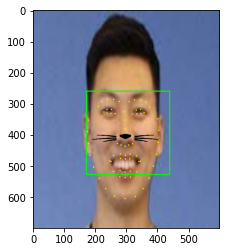

In [438]:
# print sticker with bounding bow, and landmarks
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]
img_show[refined_y:refined_y+h, refined_x:refined_x+w] = np.where(img_sticker>0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

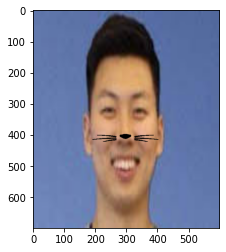

In [439]:
# print sticker without bounding bow, and landmarks
sticker_area2 = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]
img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = np.where(img_sticker>0,sticker_area2,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고
이번 프로젝트에서 어려웠던 점
- np.where()의 작동원리를 처음에 이해하지 못하여 스티커의 공백 부분을 지우기 어려웠다.

프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
- 얼굴과 관련된 작업을 진행할 때는 face detection을 먼저 진행한 후에 다른 작업을 하면 훨씬 더 쉽게 할 수 있다.

카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점
- 현재 스티커를 원본 이미지에 적용할 때는 좌표가 아닌 단순히 가로, 세로 영역으로 해서 넣는다. 따라서 얼굴의 각도가 달라진다면 스티커는 얼굴과 같이 회전하여 적용되는 것이 아니라, 지금처럼의 반듯한 위치로만 적용이 가능하다.
- 또한 스티커 이미지 중 하얀색 배경을 제거하는 작업에서 밝기가 0인 부분을 제거하도록 했지만, 사진 밝기가 증가하여 0과 가까워진다면 스티커 이미지와의 합성 단계에서 원본 이미지도 같이 제거되는 일이 발생할 수 있다.

자기 다짐
- 프로젝트를 진행할 때 처음부터 정리를 잘해가면서 조금 더 많은 설명을 써야겠다.